In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow, nltk, re, warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
file_path = '/content/drive/MyDrive/news-classification.csv'

df = pd.read_csv(file_path)

df.head(1)

,data_id,id,date,source,title,content,author,url,published,published_utc,collection_utc,category_level_1,category_level_2
0,1809,abcnews--2019-10-31--Virginia mom charged with...,2019-10-31,abcnews,Virginia mom charged with murder in 2-year-old...,The Virginia woman whose 2-year-old son was fo...,NaN,https://abcnews.go.com/US/wireStory/virginia-m...,"Thu, 31 Oct 2019 16:49:56 -0400",1572554996,1572559512,"crime, law and justice",crime


In [ ]:
df.isnull().sum()

,0
data_id,0
id,0
date,0
source,0
title,0
content,0
author,3312
url,0
published,0
published_utc,0


In [ ]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(10917, 13)
(10917, 13)


In [ ]:
df['category_level_1'].value_counts(normalize=True)

,proportion
category_level_1,
society,0.100760
sport,0.083081
politics,0.082440
"conflict, war and peace",0.073280
religion and belief,0.073280
science and technology,0.073280
labour,0.064395
health,0.064120
education,0.055601


In [ ]:
df.replace({'category_level_1': {'society': 0, 'sport': 1, 'politics': 2, 'conflict, war and peace': 3, 'religion and belief': 4, 'science and technology': 5,
                                 'labour': 6, 'health': 7, 'education': 8, 'environment': 9, 'human interest': 10, 'crime, law and justice': 11, 'disaster, accident and emergency incident': 12,
                                 'weather': 13, 'economy, business and finance': 14, 'arts, culture, entertainment and media': 15, 'lifestyle and leisure': 16}}, inplace=True)
df['category_level_1'].value_counts()

,count
category_level_1,
0,1100
1,907
2,900
3,800
4,800
5,800
6,703
7,700
8,607


In [ ]:
import pandas as pd
import pickle

def load_mapping(mapping_file):
    with open(mapping_file, 'rb') as f:
        return pickle.load(f)

In [ ]:
mappings = {
    11: { 'crime': 0, 'judiciary': 1, 'justice': 2, 'law': 3, 'law enforcement': 4 },
    15: { 'arts and entertainment': 0, 'culture': 1, 'mass media': 2 },
    14: { 'business information': 0, 'economic sector': 1, 'economy': 2, 'market and exchange': 3 },
    12: { 'accident and emergency incident': 0, 'disaster': 1, 'emergency incident': 2, 'emergency planning': 3, 'emergency response': 4 },
    9: { 'climate change': 0, 'conservation': 1, 'environmental politics': 2, 'environmental pollution': 3, 'natural resources': 4, 'nature': 5 },
    8: { 'parent organisation': 0, 'religious education': 1, 'school': 2, 'social learning': 3, 'teaching and learning': 4, 'vocational education': 5 },
    7: { 'diseases and conditions': 0, 'health facility': 1, 'health organisations': 2, 'health treatment': 3, 'healthcare policy': 4, 'medical profession': 5, 'non-human diseases': 6 },
    10: { 'accomplishment': 0, 'animal': 1, 'anniversary': 2, 'ceremony': 3, 'people': 4, 'plant': 5 },
    16: { 'exercise and fitness': 0, 'leisure': 1, 'lifestyle': 2 },
    2: { 'election': 0, 'fundamental rights': 1, 'government': 2, 'government policy': 3, 'international relations': 4, 'non-governmental organisation': 5, 'political crisis': 6, 'political dissent': 7, 'political process': 8 },
    6: { 'employment': 0, 'employment legislation': 1, 'labour market': 2, 'labour relations': 3, 'retirement': 4, 'unemployment': 5, 'unions': 6 },
    4: { 'interreligious dialogue': 0, 'religious belief': 1, 'religious conflict': 2, 'religious event': 3, 'religious facilities': 4, 'religious institutions and state relations': 5, 'religious leader': 6, 'religious text': 7 },
    5: { 'biomedical science': 0, 'mathematics': 1, 'natural science': 2, 'scientific institution': 3, 'scientific research': 4, 'scientific standards': 5, 'social sciences': 6, 'technology and engineering': 7 },
    0: { 'communities': 0, 'demographics': 1, 'discrimination': 2, 'emigration': 3, 'family': 4, 'immigration': 5, 'mankind': 6, 'social condition': 7, 'social problem': 8, 'values': 9, 'welfare': 10 },
    1: { 'bodybuilding': 0, 'competition discipline': 1, 'disciplinary action in sport': 2, 'drug use in sport': 3, 'sport event': 4, 'sport industry': 5, 'sport organisation': 6, 'sport venue': 7, 'transfer': 8 },
    3: { 'act of terror': 0, 'armed conflict': 1, 'civil unrest': 2, 'coup d\'etat': 3, 'massacre': 4, 'peace process': 5, 'post-war reconstruction': 6, 'prisoners of war': 7 },
    13: { 'weather forecast': 0, 'weather phenomena': 1, 'weather statistic': 2, 'weather warning': 3 }
}

# Replace values for each level_1 category
for level_1_cat, mapping_dict in mappings.items():
    mask = df['category_level_1'] == level_1_cat
    df.loc[mask, 'category_level_2'] = df.loc[mask, 'category_level_2'].map(mapping_dict)

# Verify the replacement
print(df['category_level_2'].value_counts())

category_level_2
0     1702
2     1702
1     1700
3     1500
4     1300
5     1106
6      800
7      600
8      307
10     100
9      100
Name: count, dtype: int64


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate the class weights
labels = df['category_level_1']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)

label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
class_weight_dict = {label_mapping[label]: weight for label, weight in zip(np.unique(labels), class_weights)}

print(class_weight_dict)

{0: 0.5837967914438502, 1: 0.70802256955704, 2: 0.7135294117647059, 3: 0.8027205882352941, 4: 0.8027205882352941, 5: 0.8027205882352941, 6: 0.9134800435110033, 7: 0.9173949579831933, 8: 1.0579513518751817, 9: 1.0702941176470588, 10: 1.0702941176470588, 11: 1.2843529411764707, 12: 1.2843529411764707, 13: 1.6054411764705883, 14: 1.6054411764705883, 15: 2.1405882352941177, 16: 2.1405882352941177}
{0: 0.5837967914438502, 1: 0.70802256955704, 2: 0.7135294117647059, 3: 0.8027205882352941, 4: 0.8027205882352941, 5: 0.8027205882352941, 6: 0.9134800435110033, 7: 0.9173949579831933, 8: 1.0579513518751817, 9: 1.0702941176470588, 10: 1.0702941176470588, 11: 1.2843529411764707, 12: 1.2843529411764707, 13: 1.6054411764705883, 14: 1.6054411764705883, 15: 2.1405882352941177, 16: 2.1405882352941177}


In [ ]:
x = df.drop(['category_level_1', 'date', 'data_id', 'author', 'url', 'published', 'published_utc', 'collection_utc', 'category_level_2'], axis=1)
y = df['category_level_1']
y_2 = df['category_level_2']

In [ ]:
data = x.copy()
data.head(1)

,id,source,title,content
0,abcnews--2019-10-31--Virginia mom charged with...,abcnews,Virginia mom charged with murder in 2-year-old...,The Virginia woman whose 2-year-old son was fo...


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Function to preprocess text
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [lem.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)

In [ ]:
# Apply preprocessing to each column and combine the text
data['id'] = data['id'].apply(preprocess_text)
data['source'] = data['source'].apply(preprocess_text)
data['title'] = data['title'].apply(preprocess_text)
data['content'] = data['content'].apply(preprocess_text)

data['combined_text'] = data['id'] + ' ' + data['source'] + ' ' + data['title'] + ' ' + data['content']

# Create the corpus
corpus = data['combined_text'].tolist()

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# Ensure corpus is a numpy array
corpus = np.array(corpus)
y = np.array(y)
y_2 = np.array(y_2)

# Split corpus into training+validation and test sets with stratified sampling on y
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_val_index, test_index in sss1.split(corpus, y):
    X_train_val, X_test = corpus[train_val_index], corpus[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]
    y_train_val_level_2, y_test_level_2 = y_2[train_val_index], y_2[test_index]

# Split training+validation set into training and validation sets with stratified sampling on y_train_val
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in sss2.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]
    y_train_level_2, y_val_level_2 = y_train_val_level_2[train_index], y_train_val_level_2[val_index]

# Print shapes to verify the splits
print("Train set shape:", X_train.shape, y_train.shape, y_train_level_2.shape)
print("Validation set shape:", X_val.shape, y_val.shape, y_val_level_2.shape)
print("Test set shape:", X_test.shape, y_test.shape, y_test_level_2.shape)

Train set shape: (8842,) (8842,) (8842,)
Validation set shape: (983,) (983,) (983,)
Test set shape: (1092,) (1092,) (1092,)


In [ ]:
import pandas as pd

base_path = "/content/drive/My Drive/"

# Convert to DataFrames and save as .csv files
pd.DataFrame(X_train).to_csv(base_path + 'X_train.csv', index=False)
pd.DataFrame(X_val).to_csv(base_path + 'X_val.csv', index=False)
pd.DataFrame(X_test).to_csv(base_path + 'X_test.csv', index=False)

pd.DataFrame(y_train).to_csv(base_path + 'y_train.csv', index=False)
pd.DataFrame(y_val).to_csv(base_path + 'y_val.csv', index=False)
pd.DataFrame(y_test).to_csv(base_path + 'y_test.csv', index=False)

pd.DataFrame(y_train_level_2).to_csv(base_path + 'y_train_level_2.csv', index=False)
pd.DataFrame(y_val_level_2).to_csv(base_path + 'y_val_level_2.csv', index=False)
pd.DataFrame(y_test_level_2).to_csv(base_path + 'y_test_level_2.csv', index=False)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
max_sentence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sentence_length, padding='post')
padded_sequences_val = pad_sequences(sequences_val, maxlen=max_sentence_length, padding='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sentence_length, padding='post')

# Save the tokenizer and max_sentence_length for later use
tokenizer_filename = f'/content/drive/MyDrive/Tokenizer_model_level_1.pkl'
max_len_filename = f'/content/drive/MyDrive/Max_len_level_1.pkl'

with open(tokenizer_filename, 'wb') as f:
    pickle.dump(tokenizer, f)

with open(max_len_filename, 'wb') as f:
    pickle.dump(max_sentence_length, f)

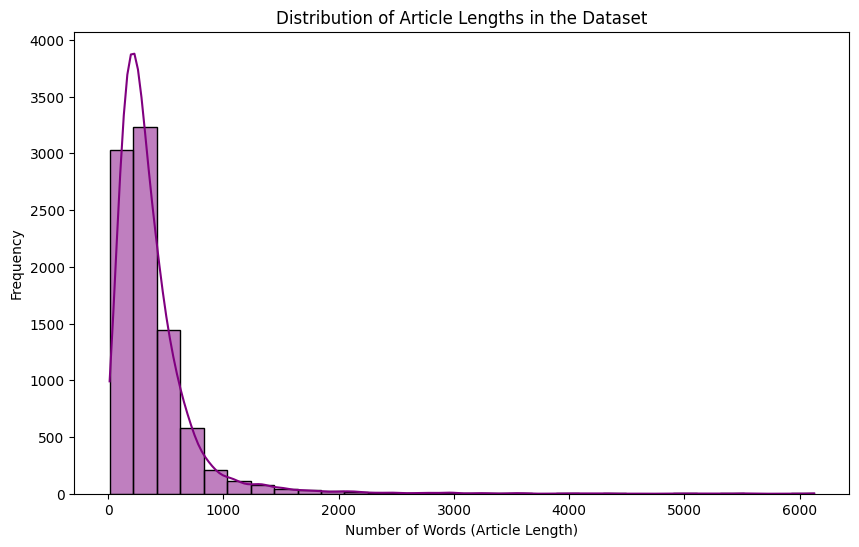

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the lengths of articles
article_lengths = [len(seq) for seq in sequences]

# Plotting the distribution of article lengths
plt.figure(figsize=(10, 6))
sns.histplot(article_lengths, bins=30, kde=True, color='purple')
plt.title('Distribution of Article Lengths in the Dataset')
plt.xlabel('Number of Words (Article Length)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import gensim
import pandas as pd

usefull_info = [gensim.utils.simple_preprocess(text) for text in X_train]
usefull_info

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
word2vec_model = gensim.models.Word2Vec(
    sentences=usefull_info,
    vector_size=200,
    window=10,
    min_count=2,
    workers=4,
)

In [ ]:
word2vec_model.build_vocab(usefull_info, progress_per=1000)

In [ ]:
word2vec_model.epochs

5

In [ ]:
word2vec_model.train(usefull_info, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

(16249458, 16557535)

In [ ]:
# Create the embedding matrix
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print(vocab_size)
print(embedding_dim)
for word, index in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[index] = word2vec_model.wv[word]

76285
200


In [ ]:
weights_assigned = {0: 0.5837967914438502, 1: 0.70802256955704, 2: 0.7135294117647059, 3: 0.8027205882352941, 4: 0.8027205882352941, 5: 0.8027205882352941, 6: 0.9134800435110033, 7: 0.9173949579831933, 8: 1.0579513518751817, 9: 1.0702941176470588, 10: 1.0702941176470588, 11: 1.2843529411764707, 12: 1.2843529411764707, 13: 1.6054411764705883, 14: 1.6054411764705883, 15: 2.1405882352941177, 16: 2.1405882352941177}

In [ ]:
learning_rate = 0.001
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
from tensorflow.keras.layers import LeakyReLU, SpatialDropout1D, GlobalMaxPooling1D

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sentence_length, weights=[embedding_matrix], trainable=True))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(BatchNormalization())
model.add(SpatialDropout1D(0.3))

model.add(GlobalMaxPooling1D())

model.add(Dense(17, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      15,257,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,257,000 (58.20 MB)

 Trainable params: 15,257,000 (58.20 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8842,)
y_train shape: (8842,)
X_val shape: (983,)
y_val shape: (983,)
X_test shape: (1092,)
y_test shape: (1092,)


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

patience = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

model_history = model.fit(padded_sequences, y_train, validation_data=(padded_sequences_val, y_val), epochs=50, batch_size = 128, class_weight=weights_assigned, callbacks=[early_stopping], verbose =1)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 59s 761ms/step - accuracy: 0.0863 - loss: 6.9570 - val_accuracy: 0.1068 - val_loss: 2.7423
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 54s 774ms/step - accuracy: 0.2135 - loss: 2.5313 - val_accuracy: 0.3032 - val_loss: 2.4383
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 796ms/step - accuracy: 0.3157 - loss: 2.1789 - val_accuracy: 0.5168 - val_loss: 2.0534
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 798ms/step - accuracy: 0.4072 - loss: 1.8799 - val_accuracy: 0.5941 - val_loss: 1.7101
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 802ms/step - accuracy: 0.4660 - loss: 1.6693 - val_accuracy: 0.6144 - val_loss: 1.4208
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 801ms/step - accuracy: 0.5045 - loss: 1.5152 - val_accuracy: 0.6439 - val_loss: 1.2383
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 802ms/step - accuracy: 0.5533 - loss: 1.3515 - val_accuracy: 0.6745 - val_loss: 1.1237
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 800ms/step - accuracy: 0.5788 - loss: 1.2841 - val_accu

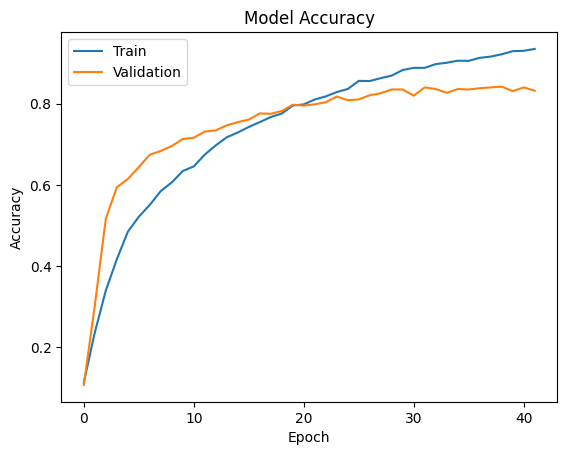

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

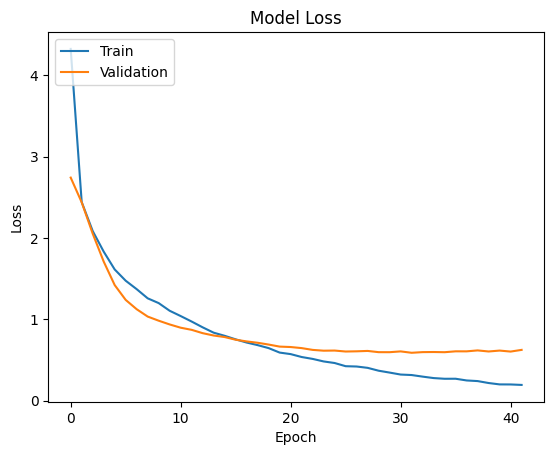

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
# Predict on training and test data
y_pred_train = model.predict(padded_sequences)
y_pred_train = np.argmax(y_pred_train, axis=1)

y_pred_test = model.predict(padded_sequences_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Print accuracy
print('Accuracy on training set:', accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy on test set:', accuracy_score(y_pred_test, y_test) * 100)

# Print correct and incorrect predictions
print("Correct predictions on training data:", sum(y_train == y_pred_train))
print("Correct predictions on test data:", sum(y_test == y_pred_test))

print("Incorrect predictions on training data:", sum(y_train != y_pred_train))
print("Incorrect predictions on test data:", sum(y_test != y_pred_test))

# Print confusion matrix
print('Confusion matrix on training data:\n', confusion_matrix(y_train, y_pred_train))
print('Confusion matrix on test data:\n', confusion_matrix(y_test, y_pred_test))

# Print classification report
print("Classification report of training data:\n", classification_report(y_train, y_pred_train, digits=4))
print("Classification report of test data:\n", classification_report(y_test, y_pred_test, digits=4))

277/277 ━━━━━━━━━━━━━━━━━━━━ 44s 158ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
Accuracy on training set: 96.59579280705722
Accuracy on test set: 82.32600732600733
Correct predictions on training data: 8541
Correct predictions on test data: 899
Incorrect predictions on training data: 301
Incorrect predictions on test data: 193
Confusion matrix on training data:
 [[806   1  11   1  12   8   8  14  10   4   6   3   3   0   1   3   0]
 [  0 721   0   0   1   0   0   0   1   0   2   0   1   0   0   2   6]
 [  6   0 679   7   8   3   8   0   2   2   1  10   2   0   1   0   0]
 [  0   0   4 641   1   0   0   0   0   0   0   0   2   0   0   0   0]
 [  1   0   4   0 626   0   0   2  11   1   0   1   1   0   0   1   0]
 [  2   1   2   0   3 596   1  24   8   3   5   0   0   0   2   0   1]
 [  1   0   0   0   0   0 564   1   0   0   0   1   0   0   3   0   0]
 [  1   0   0   0   0   2   2 560   1   0   0   1   0   0   0   0   0]
 [  1   0   0   0   4   3   3   0 480   0   0   0   0   0   0 

In [ ]:
model_save_path = "/content/drive/My Drive/model_first_level.keras"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/model_first_level.keras
